# Collect imagery 

Prequisites: 
- city outline geojson available
- gbdx account and credentials loaded
- s3 account and credentials loaded

Steps:
1. load geojson
1. generate search grid
1. loop over grid 
    - find best match
    - download image locally
    - if drive capacity is <20%, upload to s3

In [36]:
# geospatial operations on points, polygons, polylines (e.g. shapes) 
import shapely

# shapely function to create shapely object from GeoJSON
from shapely.geometry import shape, Polygon

## dealing with files
# we use fiona to read shapefiles
import geopandas as gpd
import geopandas
import fiona
# we use ogr to write shapefiles
# from osgeo import ogr

import matplotlib.pyplot as plt

from shapely.ops import cascaded_union
from shapely.geometry import MultiPolygon, Polygon, Point, MultiPoint
from itertools import chain

from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

from shapely.ops import cascaded_union, unary_union
from shapely.affinity import translate

import numpy as np
import slidingwindow as sw
from tqdm.notebook import tqdm

import glob

import warnings
warnings.filterwarnings('ignore')

In [37]:
def wgs2epsg(x,y):
    EPSG = int(32700-round((45+y)/90,0)*100+round((183+x)/6,0))
    UTM_EPSG_code = EPSG
    
    return UTM_EPSG_code

In [74]:
city_shapes = glob.glob('./tmp/city_jsons/*.geojson')

In [75]:
city_shapes[0:10]

['./tmp/city_jsons/Batam.geojson',
 './tmp/city_jsons/Los Angeles, USA.geojson',
 './tmp/city_jsons/Hengelo, Netherlands.geojson',
 './tmp/city_jsons/Canberra, Australia.geojson',
 './tmp/city_jsons/Medan.geojson',
 './tmp/city_jsons/Pekanbaru.geojson',
 './tmp/city_jsons/Bandar Lampung.geojson',
 './tmp/city_jsons/Pematang Siantar.geojson',
 './tmp/city_jsons/Tangerang Selatan.geojson',
 './tmp/city_jsons/Pontianak.geojson']

'MultiPolygon' object has no attribute 'exterior'


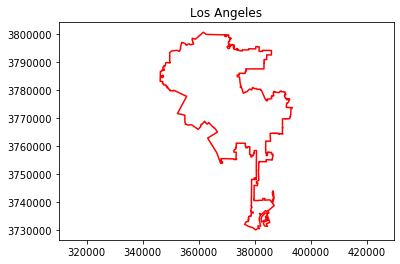

In [41]:
# run if getting shape from file

for city_shape in city_shapes[1:2]: 

    gdf = geopandas.read_file(city_shape)
    
    city = city_shape.split('/')[-1].split('.')[0].split(',')[0]

    shp_city_land= gdf.geometry
    
    if len(shp_city_land) > 1:
        shp_city_land = unary_union(shp_city_land)
    else:
        shp_city_land =shp_city_land[0]

    import warnings
    warnings.filterwarnings('ignore')

    try:
        x,y = shp_city_land.centroid.xy
        epsg = wgs2epsg(x[0], y[0])
    except Exception as e:
        print(e)
        x,y = shp_city_land[0].centroid.xy
        epsg = wgs2epsg(x[0], y[0])

    #  EPSG:32748 is also known as WGS 84 / UTM zone 48S

    # set projections
    project_wgs2utm = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:{}'.format(epsg)))

    project_utm2wgs = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:{}'.format(epsg)), # from
        pyproj.Proj(init='epsg:4326'))            # to

    shp_city_land_utm = transform(project_wgs2utm, shp_city_land)


    
    try:
        x,y = shp_city_land_utm.exterior.xy
        plt.plot(x,y,color = 'r')
        
    except Exception as e:
        print(e)
        for shp in shp_city_land_utm: 
            x,y = shp.exterior.xy
            plt.plot(x,y,color = 'r')
    
    
    plt.axis('equal')

    plt.title(str(city))

    plt.axis('equal')
    plt.show()

'MultiPolygon' object has no attribute 'exterior'


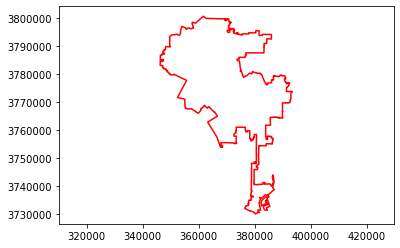

In [42]:


x,y = shp_city_land.centroid.xy
epsg = wgs2epsg(x[0], y[0])

#  EPSG:32748 is also known as WGS 84 / UTM zone 48S

# set projections
project_wgs2utm = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:{}'.format(epsg)))

project_utm2wgs = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:{}'.format(epsg)), # from
    pyproj.Proj(init='epsg:4326'))            # to

shp_city_land_utm = transform(project_wgs2utm, shp_city_land)



try:
    x,y = shp_city_land_utm.exterior.xy
    plt.plot(x,y,color = 'r')

except Exception as e:
    print(e)
    for shp in shp_city_land_utm: 
        x,y = shp.exterior.xy
        plt.plot(x,y,color = 'r')

plt.axis('equal')


plt.show()

In [79]:
# search grid parameters
patch_size = 4000 # in meters
overlap_frac = 0.1

In [80]:
minx,miny,maxx,maxy = shp_city_land_utm.bounds
grid = np.zeros([int((maxx-minx)/100),int((maxy-miny)/100)])

patch_size = int(patch_size / 100)

windows_sw = sw.generate(grid, ['w','h'], patch_size, overlap_frac)

grid = []

for window in tqdm(windows_sw):
    
    x = window.x * 100
    y = window.y * 100
    h = window.h * 100
    w = window.w * 100
    
    vertices = []
    vertices.append((minx + x    , miny + y))
    vertices.append((minx + x + w, miny + y))
    vertices.append((minx + x + w, miny + y + h))
    vertices.append((minx + x    , miny + y + h))
    vertices.append((minx + x    , miny + y))
    
    
    
    poly = Polygon(vertices)
    
    grid.append(poly)
    
    

intersect_city_list_wgs = []

for box in tqdm(grid):
    
    if shp_city_land_utm.intersects(box):
        
        box_wgs = transform(project_utm2wgs, box)
        intersect_city_list_wgs.append(box_wgs)




'MultiPolygon' object has no attribute 'exterior'


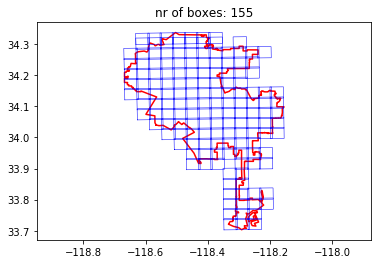

In [81]:
try:
    x,y = shp_city_land.exterior.xy
    plt.plot(x,y,color = 'r')

except Exception as e:
    print(e)
    for shp in shp_city_land: 
        x,y = shp.exterior.xy
        plt.plot(x,y,color = 'r')


for box in intersect_city_list_wgs:
    
    x,y = box.boundary.xy
    plt.plot(x,y, color  = 'b', linewidth=0.5)

plt.title('nr of boxes: ' + str(len(intersect_city_list_wgs)))
plt.axis('equal')
plt.show()

In [57]:
import csv
from datetime import datetime, timedelta

import glob

from gbdxtools.task import env
from gbdxtools import Interface, CatalogImage
from gbdx_auth import gbdx_auth


from shapely.geometry import MultiPolygon
from shapely.wkt import dumps, loads

import json
import numpy as np
import pandas as pd
gbdx_auth = gbdx_auth.get_session()

gbdx = Interface()


%matplotlib inline

In [ ]:
from gbdx_auth import gbdx_auth

gbdx = gbdx_auth.get_session("/home/ubuntu/.gbdx_config")

# GET the set of workflow tasks:
r = gbdx.get("https://geobigdata.io/workflows/v1/tasks")
task_list = r.json()
print (task_list)

In [ ]:
results = gbdx.catalog.search(searchAreaWkt=wkt_string,
                                  filters=filters)

In [61]:
# set variables
SCALE = 10;
polarization = 'VV'; # vertical/vertical or vertical/horizontal
waterThreshold = -12; 

verbose = True
get_image = True
ordering_more_images = True

path_orders_file = './tmp/data/gbdx_orders/order_id_store.csv'

metadata_file_path = './tmp/data/gbdx_orders/metadata'

city_name = 'scale_test'

t_max = datetime.now()

# define filters for GBDX search
filters = [
    "(sensorPlatformName ='WORLDVIEW02' OR sensorPlatformName ='WORLDVIEW03')",
    "cloudCover < 20"
            ]

# check for existing files

# find files in shapefile folder
shape_file_path = './tmp/data/grid_run/*.tif'
shape_files = glob.glob(shape_file_path)


id_list_done = [file.split('/')[-1].split('_')[0] for file in shape_files]


fieldnames = ['osm_id', 'order_time', 'image_id', 'order_id']

In [62]:
from IPython.display import clear_output

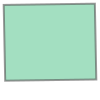

In [63]:
intersect_city_list_wgs[0]

In [64]:

from datetime import datetime


done_grid_path = metadata_file_path + '/{}_done_grid_*.csv'.format(city)


datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

path = '../../data/trainings_data_waterbodies/*.csv'

done_grid_files = glob.glob(done_grid_path)

date_list = []


# find newest file

for file in done_grid_files:
    
    # read timestamps from training data files
    try: 
        date_file = datetime.strptime(file.split('_')[-1].split('.')[0], '%Y-%m-%d %H:%M:%S')
        date_list.append(date_file)
    except Exception as e:
        # print(e)
        # files with no timestamp get old timestamp
        date_file = datetime.strptime('1900-01-01 01:00:00', '%Y-%m-%d %H:%M:%S')
        date_list.append(date_file)


date_list = np.array(date_list)


# get only nth newest file

nth_newest = 1000

try:
    index_nth_newest = np.where(date_list == (np.sort(date_list)[::-1][nth_newest]))[0][0]
    done_grid_path = done_grid_files[index_nth_newest]
    df_done_grid = pd.read_csv(done_grid_path).drop('Unnamed: 0', axis = 1)
except Exception as e:
    print(e)
    
    print('log not found')
    
    df_done_grid = pd.DataFrame(index=range(len(intersect_city_list_wgs)), 
                                columns=['geometry','status','alpha', 'overlap', 't_delta','cloud_cover', 'image_id'])

    df_done_grid.geometry = intersect_city_list_wgs
    
    df_done_grid.alpha = 0.1
    df_done_grid.status = 'grey'
    
    now = datetime.now()
    
    df_done_grid.t_delta = (now - now)


index 1000 is out of bounds for axis 0 with size 0
log not found


In [65]:

df_done_grid


,geometry,status,alpha,overlap,t_delta,cloud_cover,image_id
0,POLYGON ((-118.6670687696924 34.12073195834662...,grey,0.1,NaN,0 days,NaN,NaN
1,POLYGON ((-118.6677063348852 34.15318555597776...,grey,0.1,NaN,0 days,NaN,NaN
2,POLYGON ((-118.6683449209504 34.18563897124321...,grey,0.1,NaN,0 days,NaN,NaN
3,"POLYGON ((-118.668984529465 34.21809220404614,...",grey,0.1,NaN,0 days,NaN,NaN
4,POLYGON ((-118.6696251620095 34.25054525428988...,grey,0.1,NaN,0 days,NaN,NaN
5,POLYGON ((-118.6268041447516 34.05634657842556...,grey,0.1,NaN,0 days,NaN,NaN
6,POLYGON ((-118.6274248128256 34.08880117479051...,grey,0.1,NaN,0 days,NaN,NaN
7,POLYGON ((-118.6280464748518 34.12125558945905...,grey,0.1,NaN,0 days,NaN,NaN
8,POLYGON ((-118.6286691323625 34.15370982233498...,grey,0.1,NaN,0 days,NaN,NaN
9,"POLYGON ((-118.6292927868941 34.1861638733222,...",grey,0.1,NaN,0 days,NaN,NaN


In [66]:
intersect_city_list_wgs[0].wkt

'POLYGON ((-118.6670687696924 34.12073195834662, -118.6237106024287 34.12131300575674, -118.6244006648994 34.15737333067977, -118.6677772384502 34.15679150001474, -118.6670687696924 34.12073195834662))'

In [67]:
import time
from pprint import pprint
import os
import boto3
import progressbar

In [68]:
def upload_files(city):
    
    folder = 'tmp/data/datasets/grid_run'
    city_name = city.split(',')[0]

    upload_files_path = '{}/{}*'.format(folder, city_name)
    upload_files_list = glob.glob(upload_files_path)


    print(len(upload_files_list))
    print('-------------------------------------')
    pprint(upload_files_list[0:5])


    bucket_name = "gcw-data-repository" # no trailing '/'
    folder_name = "worldview/{}".format(city_name) # no trailing '/'

    path = folder_name + "/" + upload_files_path.split('/')[-1]
    s3 = boto3.client('s3')

    upload_files_path, bucket_name, path


    for file_name in tqdm(upload_files_list):

        path = folder_name + "/" + file_name.split('/')[-1]
        s3 = boto3.client('s3')

        statinfo = os.stat(file_name)

        up_progress = progressbar.progressbar.ProgressBar(maxval=statinfo.st_size)

        up_progress.start()

        def upload_progress(chunk):
            up_progress.update(up_progress.currval + chunk)

        # print('uploading: ', file_name)

        s3.upload_file(file_name, bucket_name, path, Callback=upload_progress)

        up_progress.finish()
        
    return upload_files_list

def remove_uploaded_files(city, upload_files_list):
    
    s3 = boto3.client('s3')

    city_name = city.split(',')[0]

    bucket_name = "gcw-data-repository" # no trailing '/'
    folder_name = "worldview/{}".format(city_name) # no trailing '/'

    result = s3.list_objects(Bucket=bucket_name, Prefix=folder_name)['Contents']

    files_on_s3 = [key['Key'].split('/')[-1] for key in result]


    for file in upload_files_list:

        base_local_file = file.split('/')[-1]


        if not base_local_file in files_on_s3:
            print('not ! succesfully uploaded')

        else:
            print('success')

            print('removing file: ', file)

            os.remove(file)

In [ ]:
intersect_city_list_wgsstatus_list = []

for i in tqdm(range(len(df_done_grid))):
    
    clear_output(wait=True)
    
    if df_done_grid.status[i] == 'green' or df_done_grid.status[i] == 'yellow':
        print('already done')
        continue
    
    df_orders = pd.read_csv(path_orders_file)
    
    try:
        geom = df_done_grid.geometry[i]
        x,y = geom.exterior.xy
    except:
        geom = shapely.wkt.loads(df_done_grid.geometry[i])
        x,y = geom.exterior.xy
    
    df_done_grid.status[i] = 'blue'
    df_done_grid.alpha[i] = 1
    

    # select shape
    # geom = shp_AOIs[shape_nr]   
    try:
        x,y = geom.exterior.xy
    except:
        x,y = geom.boundary.xy

    # UTM zone and EPSG code calculator
    zone_cal = round((183+x[0])/6,0)
    EPSG = 32700-round((45+y[0])/90,0)*100+round((183+x[0])/6,0)
    UTM_EPSG_code ='EPSG:%i'  % (EPSG)
    
    UTM_EPSG_code = 'EPSG:%i' % (4326)

    # convert to wkt
    wkt_string = geom.wkt
    

    
    plt.figure(figsize = (10,10))
    plt.axis('equal')

    for i_box in range(len(df_done_grid)):
        try:
            geom_grid = df_done_grid.geometry[i_box]
            xd,yd = geom_grid.exterior.xy
        except:
            geom_grid = shapely.wkt.loads(df_done_grid.geometry[i_box])
            xd,yd = geom_grid.exterior.xy
        
        plt.plot(xd,yd, color = df_done_grid.status[i_box], alpha = df_done_grid.alpha[i_box])


    try:
        xc,yc = shp_city_land.exterior.xy
        plt.plot(xc,yc,color = 'r')

    except Exception as e:
        print(e)
        for shp in shp_city_land: 
            xc,yc = shp.exterior.xy
            plt.plot(xc,yc,color = 'r')

    plt.show()
    
    
    # create dataframe to save search results
    df = pd.DataFrame(columns=['id', 'image_id', 'cloud_cover', 'overlap', 'd_time', 'ordered', 'metadata', 'year', 'month'])
    
    if verbose:
        print('search catalog')
      
    success = False

    while success == False:

        try:
            results = gbdx.catalog.search(searchAreaWkt=wkt_string,
                                  filters=filters)

            success = True

        except Exception as e:
            print(e)
            time.sleep(5) 
        

    len(results)

    i_image = 0

    now = datetime.now().astimezone().strftime("%Y-%m-%d_%H:%M:%S%z")

    for result in results:
        image_id = result['identifier']
        cloudCover = result['properties']['cloudCover']
        year = result['properties']['timestamp'][0:4]
        month = result['properties']['timestamp'][5:7]
        ordered = CatalogImage.is_ordered(image_id)
        shape_image = loads(result['properties']['footprintWkt'])
       
        # Get timestamp
        time_image = result["properties"]["timestamp"] 

        # convert timestamp to datetime timestamp format
        time_image = datetime.strptime(time_image, "%Y-%m-%dT%H:%M:%S.%fZ")

        time_diff = time_image - t_max

        try:
            overlap_fraction = round(shape_image.intersection(geom).area/geom.area,2)
        except: 
            overlap_fraction = 0

        # Pass the row elements as key value pairs to append() function 
        df = df.append({'id' : i_image , 
                         'image_id' : image_id,
                         'cloud_cover' : cloudCover,
                         'overlap' : overlap_fraction,
                         'd_time' : time_diff,
                         'ordered' : ordered,
                         'metadata': '0',
                         'year': year,
                         'month': month },
                        ignore_index=True)

    i_image = i_image + 1            


    # check if images are available or if ordering is needed
    
    df1 = df

    df1 = df1[[int(year) > 2018 for year in df1.year]]
    print(len(df1))
    
    df1 = df1[[int(overlap) > 0.5 for overlap in df1.overlap]]
    print(len(df1))
    
    df1 = df1[[int(overlap) > 0.5 for overlap in df1.overlap]]
    
      
    try: 
        df_sorted = df.sort_values(['ordered','overlap','cloud_cover',  'd_time'] 
                                   ,ascending=[False, False,True,  False])\
        .reset_index().drop(['index', 'id'], axis = 1)
    except Exception as e:
        print(e)
    
    nr_ordered = len(df_sorted[df_sorted['ordered']  == True])
    
    print('nr images ordered found: ' + str(nr_ordered))
    
    print(df_sorted.head())
    
    try:
        image_id = df_sorted.loc[0].image_id
    except Exception as e:
        print(e)
        image_id = e
    
    df_done_grid.status[i] = 'purple'
    df_done_grid.alpha[i] = 0.5
    df_done_grid.image_id[i] = image_id

    metadata_images = []
    
    geom = geom.buffer(0.001)


    # get the right bbox for gbdx tools search
    bbox = env.inputs.get('bbox', ', '.join(map(str, geom.bounds))) #.buffer(0.0001)
    bbox = env.inputs.get('bbox', bbox)

    ## Get image from GBDX
    pansharpen = True

    # order if not ordered
    # otherwise print error and check
    
    str_id = id
    
    if verbose:
        print('getting image if needed')

    if (nr_ordered > 0 and get_image): 
        
        try:
            print("Try to get image from GBDX...")
            image = CatalogImage(image_id, 
                                 bbox=map(float, bbox.split(",")), 
                                 pansharpen = pansharpen,
                                 acomp = True)
            
            # save metadata
            with open('{}/{}.json'.format(metadata_file_path, image_id), 'w') as fp:
                json.dump(image.metadata, fp)

            print("Success")
            
            image_success = True
            
        except Exception as e:
            
            print(e)
            image_success = False

            
    else:
            
        try: 
            image_success = False
            ordered = CatalogImage.is_available(image_id)

            print('image ordered: ' + str(ordered))

        except Exception as e:
            image_success = False
            print('error')
            print('continue ordering images')
    
    if not image_success: 
        
        if sum(df_orders.image_id == image_id) > 0:
            
            print('image already ordered')
        
            df_done_grid.status[i] = 'yellow'
            df_done_grid.alpha[i] = 0.5
            df_done_grid.cloud_cover[i] = df_sorted.loc[0].cloud_cover
            df_done_grid.overlap[i] = df_sorted.loc[0].overlap
            df_done_grid.t_delta[i] = df_sorted.loc[0].d_time
            continue
            
        else:
            
            if ordering_more_images:
                
                print('could not get image, order image')
                order_id = gbdx.ordering.order(image_id)
            
            else:
                print('could not get image, skipping image')
                order_id = '10'
                

            with open(path_orders_file, 'a') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writerow({'osm_id':str_id, 'order_time': now, 'image_id': image_id, 'order_id': order_id})

            print("Image {} ordered with order id: {}".format(image_id, order_id))
            
            
            df_done_grid.status[i] = 'orange'
            df_done_grid.alpha[i] = 0.5
            df_done_grid.cloud_cover[i] = df_sorted.loc[0].cloud_cover
            df_done_grid.overlap[i] = df_sorted.loc[0].overlap
            df_done_grid.t_delta[i] = df_sorted.loc[0].d_time
            continue

   
            
    # print("Start: " + str_search_start + "\nEnd: " + str_search_end)
    
    print('image found')

    if get_image:
        # Get timestamp
        time_image = image.metadata["image"]["acquisitionDate"] 

        # convert timestamp to datetime timestamp format
        time_image = datetime.strptime(time_image, "%Y-%m-%dT%H:%M:%S.%fZ")

        print("World View image taken on {}".format( image.metadata["image"]["acquisitionDate"]))
        print('Time difference between target {} and image is: {}'.format(t_max, time_image - t_max))

        time_image_str = time_image.strftime('%Y-%m-%d_%H%M')

        path = "./tmp/data/datasets/grid_run/{}_{}_pansharpen_{}_{}_{}.tif".format(city, 
                                                                          '%03d' %df_done_grid.index[i], 
                                                                          pansharpen, 
                                                                          time_image_str,image_id)
        proj = UTM_EPSG_code

        try:
            tif = image.geotiff(
                path = path, 
                proj = proj
                             )
            print('image downloaded to' + path)
        except Exception as e:
            print(e)
            print('connection lost, try again in 5 sec...')
            time.sleep(5)
            print('retry')
            continue
            
        
        df_done_grid.status[i] = 'green'
    
    
    if verbose:
        print('finalizing loop')
    
    df_done_grid.alpha[i] = 0.5
    df_done_grid.cloud_cover[i] = df_sorted.loc[0].cloud_cover
    df_done_grid.overlap[i] = df_sorted.loc[0].overlap
    df_done_grid.t_delta[i] = df_sorted.loc[0].d_time
    
    now = datetime.now() 
    
    done_grid_path = metadata_file_path + '/{}_done_grid_{}.csv'.format(city, now)
    done_grid_path_geojson = metadata_file_path + '/{}_done_grid_{}.geojson'.format(city, now)

    df_done_grid.to_csv(done_grid_path)
    
    # write done grid to geojson
    gdf_done_grid = gpd.GeoDataFrame(df_done_grid)# 
    
    #geometry check 
    if type(gdf_done_grid.geometry[0]) == str:
        # generate geometries
        geometry_list_done_grid = [shapely.wkt.loads(s) for s in df_done_grid.geometry]
        gdf_done_grid = gpd.GeoDataFrame(df_done_grid, geometry = geometry_list_done_grid)

    
    
    gdf_done_grid_json = gdf_done_grid.drop('t_delta', axis = 1)
    gdf_done_grid_json.to_file(done_grid_path_geojson, driver = 'GeoJSON')
    
    string = !df /dev/nvme1n1p1
    if float(string[5].split(' ')[6][0:2]) > 80:
        print('disk space less than 20%, running upload script...')
        
        list_uploaded = upload_files(city)
        
        print('files uploaded, removing succesful uploads...')
        
        remove_uploaded_files(city, list_uploaded)
        
        print('local files removed')
        
    
        
    # check files on s3 and remove matches
    
    
        

In [ ]:
results = gbdx.catalog.search(searchAreaWkt=wkt_string,
                                  filters=filters)

In [ ]:
gbdx = gbdx_auth.get_session()

In [ ]:
len(results)

In [ ]:
# write done grid to geojson

done_grid_path_geojson = metadata_file_path + '/{}_done_grid_{}.geojson'.format(city, now)
gdf_done_grid_json = gdf_done_grid.drop('t_delta', axis = 1)
#gdf_done_grid = gpd.GeoDataFrame(df_done_grid)# 

gdf_done_grid_json.to_file(done_grid_path_geojson, driver = 'GeoJSON')

## Upload files to S3

In [ ]:
from pprint import pprint
import os
import boto3
import progressbar
import glob
from tqdm.notebook import tqdm

city = 'Makassar'

list_uploaded = upload_files(city)

print('files uploaded, removing succesful uploads...')

remove_uploaded_files(city, list_uploaded)

print('local files removed')

In [ ]:
remove_uploaded_files(city, list_uploaded)

print('local files removed')

In [ ]:
bucket_name = "gcw-data-repository" # no trailing '/'
folder_name = "worldview/{}".format(city_name) # no trailing '/'

path = folder_name + "/" + upload_file_path.split('/')[-1]
s3 = boto3.client('s3')

upload_file_path, bucket_name, path


for file_name in tqdm(upload_files):
    
    path = folder_name + "/" + file_name.split('/')[-1]
    s3 = boto3.client('s3')

    statinfo = os.stat(file_name)

    up_progress = progressbar.progressbar.ProgressBar(maxval=statinfo.st_size)

    up_progress.start()

    def upload_progress(chunk):
        up_progress.update(up_progress.currval + chunk)
    
    # print('uploading: ', file_name)

    s3.upload_file(file_name, bucket_name, path, Callback=upload_progress)
    
    up_progress.finish()
